In [2]:
from data_utils import *
from scipy.stats.contingency import margins
np.seterr(divide='ignore', invalid="ignore")


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# # Do we even need df? Can we just save need probabilities?
# df = Serialization.load_obj(f"stance_pipeline_full_data_{NUM_QUANTILES}_quantiles_full_data")
# bin_means = df.groupby("bin").mean()[FEATURE_COLUMNS]
# df = get_sub_marker_pairs(df)
# # Write unit test for below
# bins, comms, markers, com_markers = get_bin_com_markers(df)
pav_matrix = Serialization.load_obj("pavalanathan_cooc_data_full_data")
cooc_matrix = Serialization.load_obj("our_cooc_data_full_data")


In [4]:
class IBObj:

    def __init__(self, com_name, joint):
        """
        Holds all information related to the efficiency calculation for a particular community.
        Args:
            com_name (str): the community that efficiency is being calculated for
        """
        self.com_name = com_name
        self.joint = (joint/joint.sum()).T
        self.p_m, self.p_w = margins(self.joint)
        self.encoder = self.joint/self.p_m
        self.decoder = self.compute_listener_distribution()
        self.complexity = self.compute_complexity()
        self.informativeness = self.compute_informativeness()

    def compute_info_gain(self, joint, marginal_1, marginal_2):
        joint_info = np.log2(joint/(np.multiply(marginal_1, marginal_2)))
        expanded = np.nan_to_num(np.multiply(joint, joint_info), 0)
        total = expanded.sum()
        return total

    def compute_listener_distribution(self):
        return self.joint/self.p_w

    def compute_complexity(self):
        return self.compute_info_gain(self.joint, self.p_w, self.p_m)
    
    def compute_informativeness(self):
        listener_surprisal = np.log2(1/self.decoder)
        expanded = np.nan_to_num(np.multiply(self.joint, listener_surprisal), 0)
        total = expanded.sum()
        return total

    
    


In [5]:
min_complexity_encoder = np.array([[1, 1, 1, 1]])
max_complexity_encoder = np.diag(np.ones(4))
# rows are words
# columns are meanings
# This gets flipped in IBObj
mid_complexity_encoder = np.array([
    [1/8, 1/16, 1/32, 1/32],
    [1/16, 1/8, 1/32, 1/32],
    [1/16, 1/16, 1/16, 1/16],
    [1/4, 0, 0, 0]
])
ex_min = IBObj("min_comp", min_complexity_encoder)
ex_max = IBObj("max_comp", max_complexity_encoder)
ex_mid = IBObj("mid_comp", mid_complexity_encoder)

print(ex_mid.complexity)
print(ex_mid.informativeness)


0.375
1.375


In [8]:
def m_hat(qW_M, pM, pU_M):
    """
    :param qW_M: encoder (naming system)
    :return: optimal decoder (Bayesian listener) that corresponds to the encoder
    """
    # Each row is a meaning, each column is a word
    pMW = qW_M * pM
    pM_W = pMW.T / pMW.sum(axis=0)[:, None]
    return pM_W.dot(pU_M)

In [789]:
all_dfs = []
com_to_markers = {}
for i in tqdm(range(92)):
    curr = cooc_matrix.T.iloc[i*1112:(i+1)*1112].T
    all_dfs.append(curr)

all_ibs = []
for curr in all_dfs:
    com_name = curr.columns[0].split("_")[0]
    if com_name == "photoshopbattles":
        continue
    encoder = curr.T.to_numpy()
    curr_IB = IBObj(com_name, encoder)
    all_ibs.append(curr_IB)

100%|██████████| 92/92 [00:00<00:00, 101.92it/s]


# Reverse Annealing

In [107]:
from scipy.special import logsumexp

PRECISION = 1e-16

def marginal(pXY, axis=1):
    """:return pY (axis = 0) or pX (default, axis = 1)"""
    return pXY.sum(axis)

def conditional(pXY):
    """:return  pY_X """
    pX = pXY.sum(axis=1, keepdims=True)
    return np.where(pX > PRECISION, pXY / pX, 1 / pXY.shape[1])

def joint(pY_X, pX):
    """:return  pXY """
    return pY_X * pX[:, None]

def marginalize(pY_X, pX):
    """:return  pY """
    return pY_X.T @ pX

def bayes(pY_X, pX):
    """:return pX_Y """
    pXY = joint(pY_X, pX)
    pY = marginalize(pY_X, pX)
    return np.where(pY > PRECISION, pXY.T / pY, 1 / pXY.shape[0])

def softmax(dxy, beta=1, axis=None):
    """:return
        axis = None: pXY propto exp(-beta * dxy)
        axis = 1: pY_X propto exp(-beta * dxy)
        axis = 0: pX_Y propto exp(-beta * dxy)
    """
    log_z = logsumexp(-beta * dxy, axis, keepdims=True)
    return np.exp(-beta * dxy - log_z)

# INFORMATIONAL MEASURES

def xlogx(v):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(v > PRECISION, v * np.log2(v), 0)

def H(p, axis=None):
    """ Entropy """
    return -xlogx(p).sum(axis=axis)

def MI(pXY):
    """ mutual information, I(X;Y) """
    return H(pXY.sum(axis=0)) + H(pXY.sum(axis=1)) - H(pXY)

def DKL(p, q, axis=None):
    """ KL divergences, D[p||q] """
    return (xlogx(p) - np.where(p > PRECISION, p * np.log2(q + PRECISION), 0)).sum(axis=axis)

def gNID(pW_X, pV_X, pX):
    if len(pX.shape) == 1:
        pX = pX[:, None]
    elif pX.shape[0] == 1 and pX.shape[1] > 1:
        pX = pX.T
    pXW = pW_X * pX
    pWV = pXW.T.dot(pV_X)
    pWW = pXW.T.dot(pW_X)
    pVV = (pV_X * pX).T.dot(pV_X)
    score = 1 - MI(pWV) / (np.max([MI(pWW), MI(pVV)]))
    return score

def complexity_joint(pWM):
    """
    :param pW_M: encoder (naming system)
    :return: I(M;W)
    """
    return MI(pWM)

def complexity_split(pW_M, pM):
    """
    :param pW_M: encoder (naming system)
    :return: I(M;W)
    """
    return MI(pW_M * pM)


def accuracy(pW_M, pM, pU_M):
    """
    :param pW_M: encoder (naming system)
    :return: I(W;U)
    """
    pMW = pW_M * pM
    pWU = pMW.T @ pU_M
    return MI(pWU)
    

class IBNamingModel(object):

    def __init__(self, pM, pU_M, betas, IB_curve, qW_M):
        self.pM = pM if len(pM.shape) == 2 else pM[:, None]
        self.pU_M = pU_M
        self.I_MU = MI(pU_M * self.pM)
        self.betas = betas
        self.IB_curve = IB_curve
        self.qW_M = qW_M
        self.qW_M_orig = None
        self.F = IB_curve[0] - betas * IB_curve[1]

    def m_hat(self, qW_M):
        """
        :param qW_M: encoder (naming system)
        :return: optimal decoder (Bayesian listener) that corresponds to the encoder
        """
        pMW = qW_M * self.pM
        pM_W = pMW.T / pMW.sum(axis=0)[:, None]
        return pM_W.dot(self.pU_M)

    def complexity(self, pW_M):
        """
        :param pW_M: encoder (naming system)
        :return: I(M;W)
        """
        return MI(pW_M * self.pM)

    def accuracy(self, pW_M):
        """
        :param pW_M: encoder (naming system)
        :return: I(W;U)
        """
        pMW = pW_M * self.pM
        pWU = pMW.T @ self.pU_M
        return MI(pWU)

    def d_IB(self, pW_M):
        """
        :param pW_M: encoder (naming system)
        :return: E[D[m||m_hat]] = I(M;U) - I(W;U)
        """
        return self.I_MU - self.accuracy(pW_M)

    def fit(self, pW_M):
        """
        fits the naming system by
        :param pW_M: encoder (naming system)
        :return:
            epsilon - deviation from optimality of pW_M
            gnid - gNID between qW_M and qW_M_fit
            bl - beta_l, the value of beta that was fitted to pW_M
            qW_M_fit - the optimal IB system at bl
        """
        Fl = self.complexity(pW_M) - self.betas * self.accuracy(pW_M)
        dFl = Fl - self.F
        bl_ind = dFl.argmin()
        bl = self.betas[bl_ind]
        epsilon = dFl.min() / bl
        qW_M_fit = self.qW_M[bl_ind]
        gnid = gNID(pW_M, qW_M_fit, self.pM)
        return epsilon, gnid, bl, qW_M_fit

In [61]:
# Unit tests
# Assert that we calculate the decoder the same as them
np.testing.assert_equal(ex_mid.decoder.T, m_hat(ex_mid.encoder, ex_mid.p_m, np.diag(np.ones(4))))

# Assert that our mutual information calculation is correct
np.testing.assert_equal(ex_mid.compute_info_gain(ex_mid.joint, ex_mid.p_w, ex_mid.p_m), MI(ex_mid.joint))

# Assert that we are using DKL properly
test_a = np.array([9/25, 12/25, 4/25])
test_b = np.repeat(np.array([1/3, 1/3, 1/3])[:, np.newaxis], 3, axis=1)
np.testing.assert_almost_equal(DKL(test_a, test_b, axis=1), [0.1230613, 0.1230613, 0.1230613])

# Assert that the complexity functions return values as we would expect
np.testing.assert_equal(complexity_split(ex_mid.encoder, ex_mid.p_m), complexity_joint(ex_mid.joint))
np.testing.assert_equal(ex_mid.complexity, complexity_joint(ex_mid.joint))

In [165]:
model_dir = "/ais/hal9000/datasets/reddit/stance_pipeline/classifiers/"
filename = "zaslavsky_colour_model.pkl"
import pickle
data = pickle.load(open(model_dir + filename, 'rb'))
beta_schedule = data['betas'][::-1]
pm = data['pM']
pu_m = data['pU_M']
ib_curve = data['IB_curve']
qw_m = data['qW_M']

In [91]:
# Asserts that meanings are the rows, and columns are each stimulus
np.testing.assert_almost_equal(pu_m.sum(axis=1), np.ones(len(pm)))
# Assert multiplying in this way creates a proper joint dist
np.testing.assert_almost_equal((pu_m * pm).sum(), 1)
# Assert that the marginals of the joint are indeed pm
np.testing.assert_almost_equal((pu_m * pm).sum(axis=1).reshape(-1, 1), pm.reshape(-1, 1))

In [97]:
joint = np.diag(np.ones(330)) * pm
# First equation calculated: pw solved
# new_pm, new_pw = margins(joint)
# new_pw_m = np.zeros((330, 330))
# for i in range(len(pm)):
#     div = DKL(pu_m[i, :], pu_w[i, :])
#     new_pw_m[i, :] = new_pw * np.exp(-1*div)
#     new_pw_m = new_pw_m/new_pw_m.sum(axis=1)

In [112]:
beta_schedule[-60]

1.0072590738423028

In [103]:
max_acc_encoder = np.diag(np.ones(330))

In [115]:
accuracy(qw_m[1200], pm, pu_m)

4.347510789285019

In [378]:
# Adapted from psuedo algorithm here: https://www.nogsky.com/publication/2019-evo-ib/2019-evo-IB.pdf
def reverse_annealing(pm, pu_m, init_qwm, betas):
    # encoder is conditional probability of w|m
    # pm is marginal probability
    #assert joint.shape == (1024, 1024) # we want words to be on the rows, meanings on the columns
    curr_encoder = init_qwm#np.diag(np.ones(len(pm)))
    encoder_list = [curr_encoder]
    for i in tqdm(range(len(betas))):
        # if i == 1:
        #     break
        # Initial joint is just the initial encoder multiplied by p(m)
        new_encoder = deterministic_annealing(pm, pu_m, curr_encoder, betas[i])
        encoder_list.append(new_encoder)
        curr_encoder = new_encoder
    return encoder_list

def deterministic_annealing(pm, pu_m, qw_m, beta):
    curr_encoder = qw_m
    prev_f = 100
    new_f = complexity_split(curr_encoder, pm) - beta * accuracy(curr_encoder, pm, pu_m)
    loops = 0
    while np.abs(prev_f - new_f) >= 1e-6:
        loops += 1
        if loops >= 10:
            break
        
        joint = curr_encoder * pm
        np.testing.assert_almost_equal(joint.sum(), 1)
        # First equation calculated: pw solved
        new_pm, new_pw = margins(joint)
        print(new_pw.shape)
        new_pu_w =  np.nan_to_num(m_hat(curr_encoder, pm, pu_m), 0)
        # Instead of KL Divergence, for our case use 1/decoder as we have been
        new_pw_m = np.zeros((len(pm), len(new_pw[0])))
        # print(new_pw_m.shape)
        # assert new_pw_m.shape == (330, 330)
        for i in range(len(pm)):
            div = DKL(pu_m[i, :], new_pu_w, axis=1)
            new_pw_m[i, :] = new_pw * np.exp(-beta*div)
        # new_pw_m = new_pw_m/new_pw_m.sum(axis=1).reshape(-1, 1)
        # new_pw_m[new_pw_m<1e-45] = 0
        # new_pw_m = new_pw_m/new_pw_m.sum(axis=1).reshape(-1, 1)
        if loops == 1:
            return new_pw_m, new_pw, pu_m, new_pu_w, beta, curr_encoder
        # I_MU = MI(pm * pu_m)
        # divergence = I_MU - accuracy(curr_encoder, pm, pu_m)
        # print("Divergence:", divergence)
        # new_encoder = new_pw * np.exp(-beta * divergence)
        new_encoder = new_pw_m
        # print(new_encoder)

        Fl = complexity_split(new_encoder, pm) - beta * accuracy(new_encoder, pm, pu_m)
        # new variable setting
        prev_f = new_f
        new_f = Fl
        curr_encoder = new_encoder
        # print(prev_f)
        # print(new_f)
        # print(prev_f - new_f)
    # print("Loops:", loops)
    # print(prev_f - new_f)
    return curr_encoder

In [354]:
new_pw_m, new_pw, pu_m, new_pu_w, beta, curr_encoder = o

In [ ]:
l = vlog(self.qt)-self.beta*kl(self.ds.py_x[:,x],self.qy_t) # [=] T x 1 # scales like X*Y*T
if self.alpha==0: self.qt_x[np.argmax(l),x] = 1
else: self.qt_x[:,x] = vexp(l/self.alpha)/np.sum(vexp(l/self.alpha))

In [486]:
def da(pm, pu_m, qw_m, beta):
    CONV_THRESHOLD = 1e-16
    curr_encoder = qw_m
    prev_f = 100
    new_f = complexity_split(curr_encoder, pm) - beta*accuracy(curr_encoder, pm, pu_m)

    curr_joint = curr_encoder * pm
    np.testing.assert_almost_equal(curr_joint.sum(), 1)
    curr_pm, curr_pw = margins(curr_joint)
    np.testing.assert_almost_equal(curr_pm, pm)
    curr_mhat = m_hat(curr_encoder, pm, pu_m)

    while np.abs(prev_f - new_f) >= CONV_THRESHOLD:
        new_encoder_vals = []
        for i in range(len(pm)):
            div = DKL(pu_m[i], curr_mhat, axis=1)
            new_encoder_vals.append(div)
        stacked = np.stack(new_encoder_vals)
        sa = softmax(stacked, beta=beta, axis=1)
        pwsa = curr_pw*sa
        new_encoder = (pwsa/pwsa.sum(axis=1).reshape(-1, 1))
        assert new_encoder.shape == curr_encoder.shape

        
        new_pm, new_pw = margins(new_encoder * pm)

        new_mhat = m_hat(new_encoder, pm, pu_m)

        curr_encoder = new_encoder
        curr_pw = new_pw
        curr_mhat = new_mhat

        prev_f = new_f
        new_f = complexity_split(curr_encoder, pm) - beta*accuracy(curr_encoder, pm, pu_m)
    return curr_encoder

In [487]:
i = 300
old_da = deterministic_annealing(pm, pu_m, qw_m[-i], beta_schedule[-i])
new_da = da(pm, pu_m, qw_m[-i], beta_schedule[-i])

(1, 249)


KeyboardInterrupt: 

In [482]:
print("Old True Complexity: ", ib_curve[0][-i])
print("Old Encoder Complexity: ", complexity_split(qw_m[-i], pm))
print("New True Complexity: ", ib_curve[0][-i-1])
print("New Encoder Complexity: ", complexity_split(qw_m[-i-1], pm))
print("Our Old Complexity: ", complexity_split(old_da, pm))
print("Our New Complexity: ", complexity_split(new_da, pm))


print("Old True Accuracy: ", ib_curve[1][-i])
print("Old Encoder Accuracy: ", accuracy(qw_m[-i], pm, pu_m))
print("New True Accuracy: ", ib_curve[1][-i-1])
print("New Encoder Accuracy: ", accuracy(qw_m[-i-1], pm, pu_m))
print("Our Old Accuracy: ", accuracy(old_da, pm, pu_m))
print("Our New Accuracy: ", accuracy(new_da, pm, pu_m))




array([1., 1., 1.])

array([0.01462499, 0.00141208, 0.01516417])

In [384]:
w = da(pm, pu_m, qw_m[1400], 1)

In [379]:
i = 300
o = deterministic_annealing(pm, pu_m, qw_m[-i], beta_schedule[-i])
# print(o)

(1, 249)


Old True Complexity:  6.383602136055115
Old Encoder Complexity:  6.383602107256618
New True Complexity:  6.375372674636497
New Encoder Complexity:  6.375372675031595
Our Complexity:  6.486067751506913
Old True Accuracy:  4.348025928956325
Old Encoder Accuracy:  4.348025927177895
New True Accuracy:  4.347510789261797
New Encoder Accuracy:  4.347510789285019
Our Accuracy:  4.353454695917527


In [177]:
new_encoders = reverse_annealing(pm, pu_m, qw_m[500], beta_schedule[100:500][::-1])
new_comp = []
new_acc = []
for e in tqdm(new_encoders):
    new_comp.append(complexity_split(e, pm))
    new_acc.append(accuracy(e, pm, pu_m))

3.8104336235830694

In [683]:
print(complexity(o, pm))
print(accuracy(o, pm, pu_w))

qm_w = m_hat(qw_m[1100], pm, pu_m)
a = DKL(pu_m[0], qm_w, axis=1)
b = DKL(pu_m[1], qm_w, axis=1)
c = DKL(pu_m[2], qm_w, axis=1)
a.shape
stacked = np.stack((a, b, c))
sa = softmax(stacked, beta=beta_schedule[1100], axis=1)
pwsa = (w[0, :78]*sa)
(pwsa/pwsa.sum(axis=1).reshape(-1, 1)).sum(axis=1)

4.171377245641041
3.686277088613336


In [635]:
div = DKL(pu_m[0, :], new_pu_w, axis=1)
div

array([ 4.33327011,  4.47358122,  5.16873024, 12.03267535, 11.8366125 ,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64319325,
       49.64319325, 49.64319325, 49.64319325, 49.64319325, 49.64

In [589]:
accuracy(q, pm, pu_m)

0.7919738835890051

In [585]:
print(complexity(o, pm))
accuracy(o, pm, pu_m)

0.1290203489744936


0.12902034897435277

In [ ]:
def softmax(dxy, beta=1, axis=None):
    """:return
        axis = None: pXY propto exp(-beta * dxy)
        axis = 1: pY_X propto exp(-beta * dxy)
        axis = 0: pX_Y propto exp(-beta * dxy)
    """
    log_z = logsumexp(-beta * dxy, axis, keepdims=True)
    return np.exp(-beta * dxy - log_z)

In [342]:
betas = beta_schedule[::-1]

In [348]:
ib_curve[0][1]

1.9758117563384303e-05

In [562]:
qw_m[139]

array([[5.91046177e-01, 2.56896118e-01, 1.51183447e-01, 8.55146590e-04,
        1.91114948e-05],
       [3.51090163e-01, 5.74622798e-01, 7.34634014e-02, 5.97786034e-04,
        2.25851520e-04],
       [1.98504618e-01, 2.35554843e-02, 4.94941198e-01, 2.82977641e-01,
        2.10583353e-05],
       ...,
       [8.34086257e-01, 7.54530351e-02, 7.39749515e-02, 1.64827999e-02,
        2.95672276e-06],
       [6.79966577e-01, 3.98140962e-02, 2.09699324e-01, 7.05140303e-02,
        5.97295562e-06],
       [2.59388445e-01, 6.71360429e-01, 6.87213462e-02, 1.92262813e-04,
        3.37516538e-04]])

In [413]:
q = np.concatenate((qw_m[138], np.zeros((330, 325))), axis=1)

In [391]:
print(complexity(q, pm))
accuracy(q, pm, pu_m)

0.8030636608362567


0.7919738835890051

In [386]:
print(ib_curve[0][138])
print(ib_curve[1][138])

0.8030636683498145
0.792957196977893


133

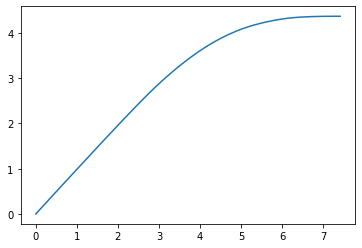

In [360]:
plt.plot(ib_curve[0], ib_curve[1])
np.argmax(ib_curve[0]>=0.7)

In [337]:
qw_m[500]

array([[8.76124723e-01, 6.35998075e-03, 2.48341036e-07, ...,
        2.21206309e-09, 4.73529757e-02, 2.40406320e-07],
       [3.49275657e-02, 1.37134662e-03, 4.03576579e-07, ...,
        1.56079620e-07, 3.85553573e-02, 6.05901524e-05],
       [6.03476117e-06, 1.97902116e-01, 7.36698875e-01, ...,
        6.24576070e-02, 8.89667785e-07, 4.12011883e-06],
       ...,
       [1.99431692e-02, 2.60929093e-04, 4.29230185e-05, ...,
        1.05637759e-03, 3.57789531e-01, 1.36024557e-08],
       [1.40123552e-04, 4.08256098e-02, 1.37111509e-02, ...,
        2.13269110e-02, 9.63760788e-04, 2.32520510e-06],
       [4.20176873e-03, 1.53999141e-03, 6.91159557e-07, ...,
        1.67863334e-08, 2.45676972e-03, 9.83491734e-05]])

In [328]:
div = DKL(o[2][0, :], o[3][0, :])
div

4.7612438757596145

In [327]:
x = np.exp(-beta*div)*o[1]
x/x.sum()

AxisError: axis 1 is out of bounds for array of dimension 0

In [325]:
beta_schedule

array([8.19200000e+03, 8.02309323e+03, 7.85766906e+03, ...,
       1.00012516e+00, 1.00000000e+00, 0.00000000e+00])

In [313]:
o = deterministic_annealing(pm, pu_m, np.diag(np.ones(330)), beta_schedule[0])

-35801.45911960366
100
35901.45911960366
8192.0
[0.01540954 0.00141249 0.01657937 0.00410181 0.00027444]
(330, 330)
-35801.45911960366
2.134709081502706e-06
-35801.45912173837
[0.01540954 0.00141249 0.01657937 0.00410181 0.00027444]
(330, 330)


In [104]:
obj = ex_mid
print(complexity(obj.encoder))
print(accuracy(obj.encoder, np.diag(np.ones(4))))
print(MI(np.diag(np.ones(4)) * obj.p_m)) #- accuracy(obj.encoder, np.diag(np.ones(4))))


-6.50945402318856


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [35]:
obj = mid_complexity_encoder
obj = obj/obj.sum()
pw, pjm = margins(obj)
encoder = obj/pjm
zas_mod = IBNamingModel(pjm, np.diag(np.ones(4)), beta_schedule, beta_schedule, encoder)

In [48]:
# from urllib.request import urlretrieve
# DEFAULT_MODEL_URL = 'https://www.dropbox.com/s/70w953orv27kz1o/IB_color_naming_model.zip?dl=1'
# urlretrieve(DEFAULT_MODEL_URL, "/ais/hal9000/datasets/reddit/stance_pipeline/classifiers/" + 'temp.zip')
# from zipfile import ZipFile
# with ZipFile(model_dir + 'temp.zip', 'r') as zf:
#     zf.extractall(model_dir)
#     os.remove(model_dir + 'temp.zip')
#     os.rename(model_dir + 'IB_color_naming_model/IB_color_naming.pkl', model_dir + filename)

('/ais/hal9000/datasets/reddit/stance_pipeline/classifiers/temp.zip',
 <http.client.HTTPMessage at 0x7fca5077fd50>)

In [ ]:
obj = mid_complexity_encoder
obj = (obj/obj.sum()).T # transform to meanings on rows
pw, pjm = margins(obj)
encoder = (obj/pjm).T
m_hat(encoder, pjm, np.diag(np.ones(4)))

In [33]:
names = []
xs = []
ys = []
for ib in all_ibs:
    names.append(ib.com_name)
    xs.append(ib.complexity)
    ys.append(ib.informativeness)
plt.scatter(xs, ys)
